In [1]:
!pip install rasterio
import os
import torch
import pickle
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms import Compose, Normalize, Resize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, GaussianBlur
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, Module, CrossEntropyLoss, Dropout, LayerNorm
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from torch import nn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.1 MB/s eta 0:00:00:00:0100:01


In [2]:
class TifImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith(".tif")]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        with rasterio.open(img_path) as src:
            image = src.read()
        image = torch.tensor(image, dtype=torch.float32)
        for band in range(image.shape[0]):
            band_data = image[band, :, :]
            nan_mask = torch.isnan(band_data)
            if nan_mask.any():
                mean_value = band_data[~nan_mask].mean()
                band_data[nan_mask] = mean_value
        if image.shape[0] > 3:
            image = image[:3, :, :]
        elif image.shape[0] < 3:
            image = image.expand(3, image.shape[1], image.shape[2])
        mask_name = img_name.replace(".tif", "_mask.tif")
        mask_path = os.path.join(self.mask_dir, mask_name)
        with rasterio.open(mask_path) as src:
            mask = src.read(1)
        total_pixels = mask.size
        non_zero_pixels = (mask > 0).sum()
        non_zero_percentage = (non_zero_pixels / total_pixels) * 100
        label = torch.tensor(1 if non_zero_percentage > 30 else 0, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# Define transformations
input_size = 224
transform = Compose([
    Resize((input_size, input_size)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomRotation(degrees=15),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Initialize dataset and DataLoader
image_dir = "oilspilldatasetfiltered/sar_ds_r_filtered_bal/image_patches"
mask_dir = "oilspilldatasetfiltered/sar_ds_r_filtered_bal/mask_patches"
dataset = TifImageDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)


In [4]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, num_classes, nhead=4, num_layers=1, dim_feedforward=4):
        super(TransformerEncoderModel, self).__init__()
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        # Flatten spatial dimensions for transformer input
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Pool across tokens
        x = self.fc(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerEncoderModel(input_dim=3, num_classes=2).to(device)
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

model.to(device)

# Class weights for imbalance
class_counts = Counter(label.item() for _, label in dataset)
class_weights = torch.tensor([1.0, len(dataset) / class_counts[1]], device=device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
epochs = 15
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}", "Accuracy": f"{100 * correct / total:.2f}%"})

    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Save checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"transformer_epoch_{epoch + 1}.pth"))


Epoch 1/15:   0%|          | 0/3496 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)
Epoch 1/15: 100%|██████████| 3496/3496 [16:47<00:00,  3.47it/s, Loss=0.4901, Accuracy=72.83%]


Epoch [1/15] - Loss: 0.5919, Accuracy: 72.83%


Epoch 2/15: 100%|██████████| 3496/3496 [11:51<00:00,  4.91it/s, Loss=0.1811, Accuracy=85.84%]


Epoch [2/15] - Loss: 0.4457, Accuracy: 85.84%


Epoch 3/15: 100%|██████████| 3496/3496 [11:50<00:00,  4.92it/s, Loss=0.1227, Accuracy=87.51%]


Epoch [3/15] - Loss: 0.3664, Accuracy: 87.51%


Epoch 4/15: 100%|██████████| 3496/3496 [11:48<00:00,  4.93it/s, Loss=0.4020, Accuracy=88.44%]


Epoch [4/15] - Loss: 0.3303, Accuracy: 88.44%


Epoch 5/15: 100%|██████████| 3496/3496 [11:49<00:00,  4.92it/s, Loss=0.2102, Accuracy=88.74%]


Epoch [5/15] - Loss: 0.3170, Accuracy: 88.74%


Epoch 6/15: 100%|██████████| 3496/3496 [11:50<00:00,  4.92it/s, Loss=0.0875, Accuracy=89.00%]


Epoch [6/15] - Loss: 0.3085, Accuracy: 89.00%


Epoch 7/15: 100%|██████████| 3496/3496 [11:49<00:00,  4.93it/s, Loss=0.0548, Accuracy=88.93%]


Epoch [7/15] - Loss: 0.3083, Accuracy: 88.93%


Epoch 8/15: 100%|██████████| 3496/3496 [11:50<00:00,  4.92it/s, Loss=0.0829, Accuracy=89.00%]


Epoch [8/15] - Loss: 0.3050, Accuracy: 89.00%


Epoch 9/15: 100%|██████████| 3496/3496 [11:49<00:00,  4.93it/s, Loss=0.0393, Accuracy=88.96%]


Epoch [9/15] - Loss: 0.3013, Accuracy: 88.96%


Epoch 10/15: 100%|██████████| 3496/3496 [11:47<00:00,  4.94it/s, Loss=0.1201, Accuracy=89.40%]


Epoch [10/15] - Loss: 0.2959, Accuracy: 89.40%


Epoch 11/15: 100%|██████████| 3496/3496 [11:48<00:00,  4.94it/s, Loss=0.0335, Accuracy=88.97%]


Epoch [11/15] - Loss: 0.2954, Accuracy: 88.97%


Epoch 12/15: 100%|██████████| 3496/3496 [11:48<00:00,  4.93it/s, Loss=1.6795, Accuracy=89.40%]


Epoch [12/15] - Loss: 0.2943, Accuracy: 89.40%


Epoch 13/15: 100%|██████████| 3496/3496 [11:49<00:00,  4.93it/s, Loss=0.3136, Accuracy=89.07%]


Epoch [13/15] - Loss: 0.2932, Accuracy: 89.07%


Epoch 14/15: 100%|██████████| 3496/3496 [11:50<00:00,  4.92it/s, Loss=0.0282, Accuracy=89.50%]


Epoch [14/15] - Loss: 0.2888, Accuracy: 89.50%


Epoch 15/15: 100%|██████████| 3496/3496 [11:55<00:00,  4.88it/s, Loss=0.0729, Accuracy=89.55%]

Epoch [15/15] - Loss: 0.2883, Accuracy: 89.55%


Confusion Matrix:
[[3059  437]
 [ 264 3232]]

Classification Report:
              precision    recall  f1-score   support

no oil spill       0.92      0.88      0.90      3496
   oil spill       0.88      0.92      0.90      3496

    accuracy                           0.90      6992
   macro avg       0.90      0.90      0.90      6992
weighted avg       0.90      0.90      0.90      6992

Precision: 0.88
Recall (Sensitivity, TPR): 0.92
F1 Score: 0.90
Cohen's Kappa: 0.80
True Positive Rate (TPR): 0.92
True Negative Rate (TNR): 0.88
False Positive Rate (FPR): 0.12
False Negative Rate (FNR): 0.08


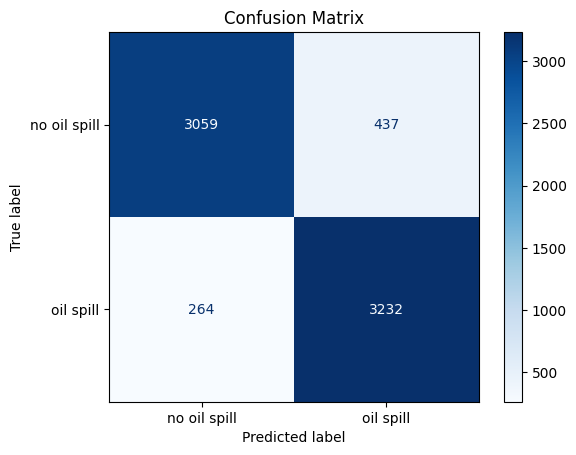

In [14]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    classification_report
)
import matplotlib.pyplot as plt

# Step 2: Evaluate and Collect Predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 3: Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['no oil spill', 'oil spill']  # Replace with your class names if needed

# Extract True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Metrics Calculations
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
kappa = cohen_kappa_score(all_labels, all_preds)
TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # True Positive Rate (Sensitivity)
TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate (Specificity)
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  # False Negative Rate

# Display Metrics
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity, TPR): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"True Negative Rate (TNR): {TNR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"False Negative Rate (FNR): {FNR:.2f}")

# Step 4: Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()